### Goal of this project
1. Investigate and visualise titanic passenger's data
2. Applying various statistical/machine learning methods for prediction, and compares their performances.
3.  List out factors highly related to survival

### Findings
1. Passenger's ticket fare, ticket class, sex, and age are highly related to survival. 
2. XgBoost provide the best prediction.
3. Young females, passengers with higher ticket class are more likely to survive. 

In [161]:
!pip install pandas numpy matplotlib seaborn scipy tqdm scikit-learn xgboost


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import xgboost as xgb
from scipy import stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [163]:
# Data and figure directories
dataset_dir = os.path.join(".", "assignment_datasets")
fig_dir = os.path.join(".", "figures")

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# plot style
plt.style.use('ggplot')
plt.rc("axes", titlesize=15)
plt.rc("axes", labelsize=13)
plt.rc("legend", fontsize=12)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)

In [164]:
print(os.path)

<module 'posixpath' from '/Users/chia-hsinlin/opt/anaconda3/envs/dl/lib/python3.9/posixpath.py'>


### Load data

In [165]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

display(train.head())
train.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [166]:
print("The train data has", train.shape[0], "rows and", train.shape[1], "columns")

The train data has 891 rows and 12 columns


### Missing values

The train data has missing values in Age (177), Cabin (687), and Embarked (2). Cabin and Age have significant missing values.

In [167]:
print(pd.isna(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


We inspect whether missing values are correlated with other variables.

We begin with the variable "Cabin". The missing values of Cabin appear to mostly correlated with ticket class (Pclass). We see 97% of the passengers with ticket class 3 have thier Cabin value missing. Similarly, 91% of the passengers with ticket class 2 have missing value in Cabin. We suspect most passengers with lower ticket class are not assigned with a cabin. 

All missing values of "Embarked" (Port of Embarkation) appear in Ticket Class 1.

Ticket with class 3 has the highest percentage of missing value in age.

In [168]:
missing_perct_by_class = (
    train.groupby(['Pclass'])
    .apply(lambda x: x.isna().sum() / len(x))
)

print("The missing value percentage is:")
display(missing_perct_by_class)

The missing value percentage is:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.138889,0.0,0.0,0.0,0.0,0.185185,0.009259
2,0.0,0.0,0.0,0.0,0.0,0.059783,0.0,0.0,0.0,0.0,0.913043,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.276986,0.0,0.0,0.0,0.0,0.975560,0.000000


### Explorary data analysis

We start from categorical variables. We see:
- Each passenger has an unique name (count = unique = 891). The title is also provided.
- Passengers are 64.8% male and 35.2% percent female.
- 23% of ticket number are duplicated.
- Multiple people share the same cabin as their are multiple duplicates.
- Most people embarked on the port Southampton (S).

In [169]:
train.describe(include=['O']) # include object data types = analyse categorical data

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


We now inspect categorical and continuous variables with graphs and see their relationship with survival rate. 

Text(0.5, 0, 'Ticket Class')

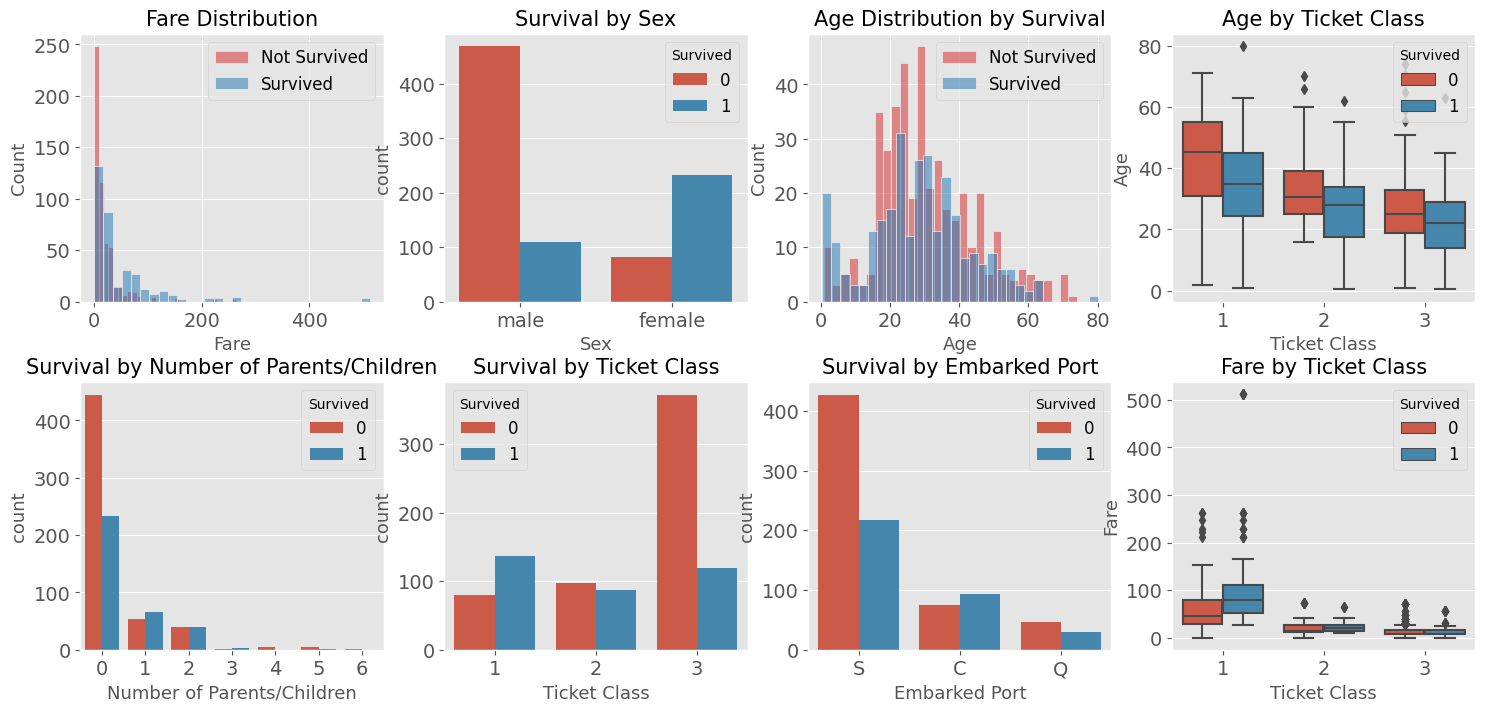

In [170]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

sns.histplot(train[train["Survived"]==0]['Fare'], bins=30, ax=axes[0,0], label='Not Survived', alpha=0.5, color='tab:red')
sns.histplot(train[train["Survived"]==1]['Fare'], bins=30, ax=axes[0,0], label='Survived', alpha=0.5, color='tab:blue')
axes[0,0].legend(['Not Survived', 'Survived'])
axes[0,0].set_title('Fare Distribution')
axes[0,0].set_xlabel('Fare')

sns.countplot(x="Sex", hue="Survived", data=train, ax=axes[0,1])
axes[0,1].set_title("Survival by Sex")

sns.histplot(train[train["Survived"]==0]['Age'], bins=30, ax=axes[0,2], label='Not Survived', alpha=0.5, color='tab:red')
sns.histplot(train[train["Survived"]==1]['Age'], bins=30, ax=axes[0,2], label='Survived', alpha=0.5, color='tab:blue')
axes[0,2].legend(['Not Survived', 'Survived'])
axes[0,2].set_title('Age Distribution by Survival')

sns.boxplot(x="Pclass", y="Age", hue="Survived", data=train, ax=axes[0,3])
axes[0,3].set_title("Age by Ticket Class")
axes[0,3].set_xlabel("Ticket Class")

sns.countplot(x='Parch', hue="Survived", data=train, ax=axes[1,0])
axes[1,0].set_title('Survival by Number of Parents/Children')
axes[1,0].set_xlabel('Number of Parents/Children')

sns.countplot(x="Pclass", hue="Survived", data=train, ax=axes[1,1])
axes[1,1].set_title("Survival by Ticket Class")
axes[1,1].set_xlabel("Ticket Class")

sns.countplot(x="Embarked", hue="Survived", data=train, ax=axes[1,2])
axes[1,2].set_title("Survival by Embarked Port")
axes[1,2].set_xlabel("Embarked Port")

sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=train, ax=axes[1,3])
axes[1,3].set_title("Fare by Ticket Class")
axes[1,3].set_xlabel("Ticket Class")

We see:
- Fare distribution is rightly skewed: this may due to that most people buy the lower ticket class (class 3). Ticket fare has 1 outlier at 500+. Most person with low ticket fare did not survive.
- The number of male passengers is twice as large as the number of female passengers. Females have much higher survival rate than males.
- The passenger age distribution is approxmiately normal with mean at 30+. Infants have higher survival rate.
- In each Ticket Class, younger people are more likely to survive. Older people tend to buy higher ticket classes.
- Most passengers do not have siblings. Passengers with 1 sibling have higher chance to survive.
- Most passengers hold class 3 tickets. People with class 3 tickets are more likely to die compared to other two higher classes.
- People Embarked through Southampton (S) is more like to die than those embarked on Cherbourg (C) and Queenstown (Q).
- Lower ticket class has lower ticket fare. In the First ticket class, higher fare lead to higher survival rate. 

We also plot the correlation matrix to see the correlation between each feature.

In [171]:
train.Sex = train.Sex == "male" # convert sex into numerical value to plot correlation plot

[Text(0.5, 0, 'PassengerId'),
 Text(1.5, 0, 'Survived'),
 Text(2.5, 0, 'Pclass'),
 Text(3.5, 0, 'Sex'),
 Text(4.5, 0, 'Age'),
 Text(5.5, 0, 'SibSp'),
 Text(6.5, 0, 'Parch'),
 Text(7.5, 0, 'Fare')]

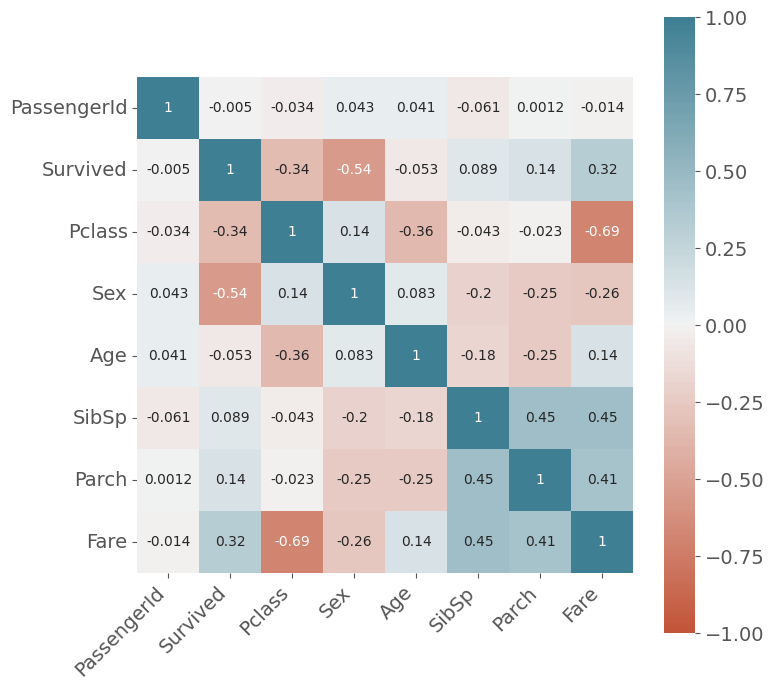

In [172]:
corr = train.corr(method="spearman", numeric_only=True)
plt.figure(figsize=(8, 8))

# show numbers on heatmap
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

The Spearman correlation analysis also shows Sex, Ticket Class, and Fare correlates with survival rate.

### Feature Engineering

#### Title
In name variable, we notice name title may capture one's age, sex, and social-economic status, which may in turn affects survival. We decide to investigate this further.

In [173]:
train["title"] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train.title, train.Sex)

Sex,False,True
title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Common titles include: Master, Miss, Mr, Mrs. We replace other rare titles with "rare". We see people with title "Miss" and "Mrs" have higher chance to survive. People with title "Mr" have lower chance to survive. We decide to include title in the training data.

In [174]:
common_titles = ["Master", "Miss", "Mr", "Mrs"]
train.title.iloc[~train.title.isin(common_titles)] = "rare"

title_survival = (
    train[["title", "Survived"]]
    .groupby(["title"])
    .mean()
)
title_survival

/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_51295/609889374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.title.iloc[~train.title.isin(common_titles)] = "rare"


,Survived
title,
Master,0.575000
Miss,0.697802
Mr,0.156673
Mrs,0.792000
rare,0.444444


#### IsAlone
From the graph Survival by Number of Parents/Children, we see people who travel alone has high chance of not surviving. We can combine the variable "SibSp" and "Parch" into a new variable called "FamilySize". Based on FamilySize, we create an additional feature "isAlone" to indicate whether a passenger travels alone. 

In [175]:
train["FamilySize"] = train.SibSp + train.Parch
train["isAlone"] = train["FamilySize"] ==0
alone_survival = (
    train[["isAlone", "Survived"]].groupby(["isAlone"])
    .mean()
)
alone_survival

,Survived
isAlone,
False,0.505650
True,0.303538


### Feature Selection
We now decide which features to train model. Based on EDA, we decide to use Age, Ticket Class, Fare, Sex, Embarked Port, Title, isAlone, and log_fare to train the model. We discard name, passenger id, Ticket number, fare, and Cabin as they do not contribute to survival prediction. We also drop SibSp and Parch as they are summarised by isAlone.

#### Filling missing values
Recall we have 2 missing values in Embarked Port and 177 missing values in Age. We need to fill them up before model training. 
- For Embarked Port, we simply use the most frequent port, Southampton (S), to fill up the 2 missing values.
- For age, we use the median age of Ticket Class to fill up each passengers value, as Ticket Class is correlated with age in the correlation plot.


In [176]:
train["Embarked"] = train["Embarked"].fillna("S") # fill missing embarked port with Southampton

In [177]:
median_age = (
    train[["Pclass", "Age"]]
    .groupby(["Pclass"])
    .median()
)
median_age

,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [178]:
median_age_dict = median_age.to_dict()["Age"]
train["Age"] = (
    train # fill missing age with median age of each ticket class
    .apply(lambda row: median_age_dict[row["Pclass"]] if pd.isna(row["Age"]) else row["Age"], axis=1 )
) 

In [179]:
# drop unnesesary colunmns for training
train = train.drop(["PassengerId", "SibSp", "Parch", "Ticket", "Cabin", "FamilySize", "Name"], axis=1)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,title,isAlone
0,0,3,True,22.0,7.2500,S,Mr,False
1,1,1,False,38.0,71.2833,C,Mrs,False
2,1,3,False,26.0,7.9250,S,Miss,True
3,1,1,False,35.0,53.1000,S,Mrs,False
4,0,3,True,35.0,8.0500,S,Mr,True


In [180]:
# encode categorical data
label_encoder_title = LabelEncoder()
label_encoder_embark = LabelEncoder()
train["title"] = label_encoder_title.fit_transform(train["title"])
train["Embarked"] = label_encoder_embark.fit_transform(train["Embarked"])

In [181]:
# scale the data
scaler = StandardScaler()
train[["Age", "Fare"]] = scaler.fit_transform(train[["Age", "Fare"]])
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,title,isAlone
0,0,3,True,-0.533834,-0.502445,2,2,False
1,1,1,False,0.674891,0.786845,0,3,False
2,1,3,False,-0.231653,-0.488854,2,1,True
3,1,1,False,0.448255,0.420730,2,3,False
4,0,3,True,0.448255,-0.486337,2,2,True


### Model training

In [182]:
# split data into train and validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [183]:
train_X, train_y = train.drop("Survived", axis=1), train["Survived"]
val_X, val_y = val.drop("Survived", axis=1), val["Survived"]

#### Logistic regression

In [184]:
logreg = LogisticRegression()
logreg.fit(train_X, train_y)
logreg.score(val_X, val_y)
print("The accuracy of the logistic regression model is:", round(logreg.score(val_X, val_y),3))

The accuracy of the logistic regression model is: 0.799


#### Decision Tree
For deicsion tree, we tune hyperparameter: number of depths using the validation set. The validation accuracy decreases at the tree depth equals to 6. We choose 6 as max_depth.

100%|██████████| 29/29 [00:00<00:00, 292.39it/s]


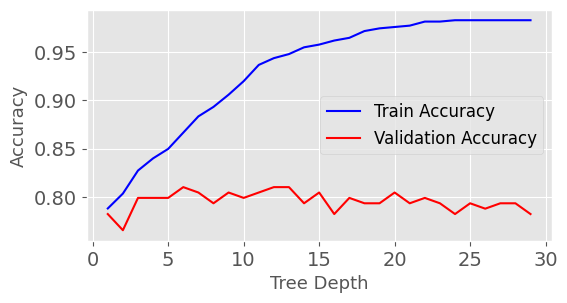

The best tree depth is: 6
The best validation accuracy is: 0.81


In [185]:
max_depths = range(1, 30)
train_results = []
val_results = []

for max_depth in tqdm(max_depths):
    decision_tree = DecisionTreeClassifier(max_depth=max_depth)
    decision_tree.fit(train_X, train_y)
    train_results.append(decision_tree.score(train_X, train_y))
    val_results.append(decision_tree.score(val_X, val_y))

plt.figure(figsize=(6,3))
plt.plot(max_depths, train_results, 'b', label='Train Accuracy')
plt.plot(max_depths, val_results, 'r', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()
print("The best tree depth is:", max_depths[np.argmax(val_results)])
print("The best validation accuracy is:", round(max(val_results),3))

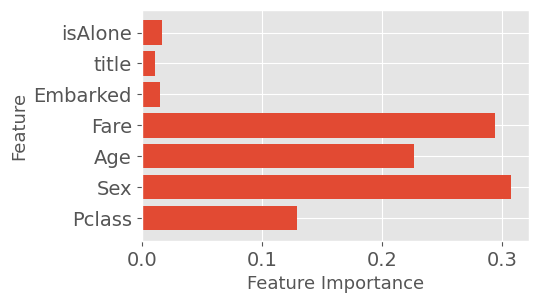

In [186]:
# plot feature importance
plt.figure(figsize=(5,3))
plt.barh(train_X.columns, decision_tree.feature_importances_, )
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

#### Random Forest

100%|██████████| 99/99 [00:04<00:00, 21.36it/s] 


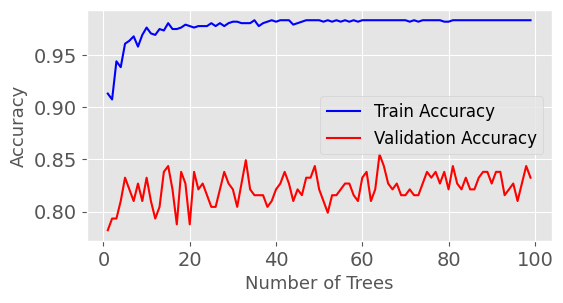

The best number of trees is: 64
The best validation accuracy is: 0.855


In [187]:
n_estimators_list = range(1, 100)
train_results = []
val_results = []

for n_estimators in tqdm(n_estimators_list):
    random_forest = RandomForestClassifier(n_estimators=n_estimators)
    random_forest.fit(train_X, train_y)
    train_results.append(random_forest.score(train_X, train_y))
    val_results.append(random_forest.score(val_X, val_y))

plt.figure(figsize=(6,3))
plt.plot(n_estimators_list, train_results, 'b', label='Train Accuracy')
plt.plot(n_estimators_list, val_results, 'r', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()
print("The best number of trees is:", n_estimators_list[np.argmax(val_results)])
print("The best validation accuracy is:", round(max(val_results),3))

Pclass = 0.09416244268019125
Sex = 0.19616172938368678
Age = 0.2475209641158314
Fare = 0.2838256192573689
Embarked = 0.03800148790239022
title = 0.11774494000661773
isAlone = 0.02258281665391372


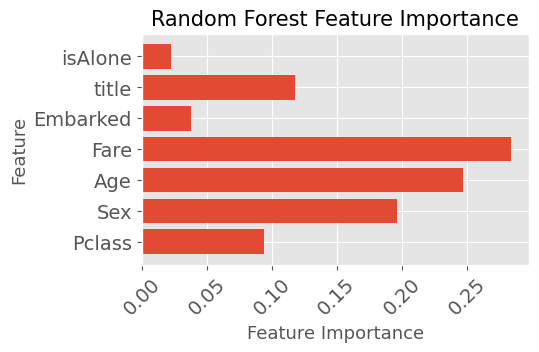

In [188]:
for name, importance in zip(train_X.columns, random_forest.feature_importances_):
    print(name, "=", importance)

# plot feature importance
plt.figure(figsize=(5,3))
plt.barh(train_X.columns, random_forest.feature_importances_, )
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.xticks(rotation=45)
plt.title('Random Forest Feature Importance')
plt.show()

#### XGBoost

In [189]:
dtrain = xgb.DMatrix(train_X, label=train_y)
dval = xgb.DMatrix(val_X, label=val_y)

params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'error', 'nthread': 3, "tree_method":'hist', 
          "early_stopping_rounds":10, "verbosity":0, "n_estimators": 50, "seed": 42}

evallist = [(dtrain, 'train'), (dval, 'eval')] # include both train and validation data to see the performance of the model
bst = xgb.XGBClassifier(**params)

bst.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X,val_y)], verbose=False) # fit the model
print(f"The accuracy of the XGBoost model is: {round(bst.score(val_X, val_y),3)} at iteration {bst.best_iteration}")

The accuracy of the XGBoost model is: 0.866 at iteration 20


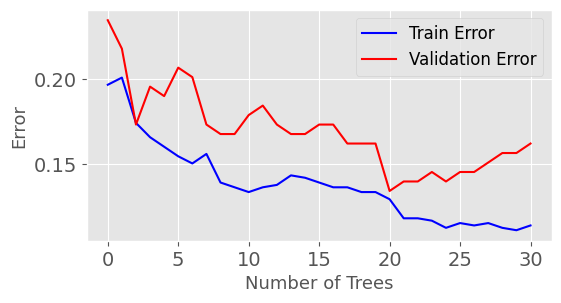

In [190]:
xgb_train_loss = bst.evals_result()['validation_0']['error']
xgb_val_loss = bst.evals_result()['validation_1']['error']

plt.figure(figsize=(6,3))
plt.plot(xgb_train_loss, 'b', label='Train Error')
plt.plot(xgb_val_loss, 'r', label='Validation Error')
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.legend()

Text(0.5, 1.0, 'XGBoost Feature Importance')

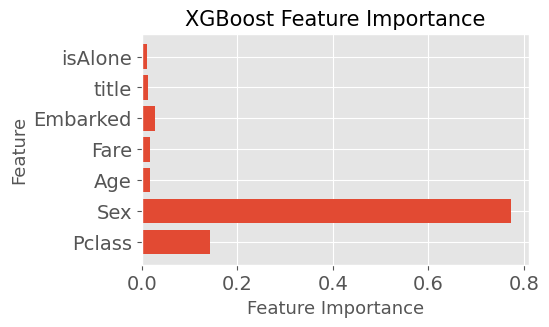

In [191]:
# plot feature importance
plt.figure(figsize=(5,3))
plt.barh(train_X.columns, bst.feature_importances_)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')

### Examine on testing data

In [226]:
test = pd.read_csv("test.csv")
passenger_id = test["PassengerId"] # for submission
test["title"] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
common_titles = ["Master", "Miss", "Mr", "Mrs"]
test.title.iloc[~test.title.isin(common_titles)] = "rare"

test["FamilySize"] = test.SibSp + test.Parch
test["isAlone"] = test["FamilySize"] ==0

/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_51295/2545382240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.title.iloc[~test.title.isin(common_titles)] = "rare"


In [227]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
title            0
FamilySize       0
isAlone          0
dtype: int64

In [228]:
test["Age"] = (
    test # fill missing age with median age of each ticket class
    .apply(lambda row: median_age_dict[row["Pclass"]] if pd.isna(row["Age"]) else row["Age"], axis=1 )
) 
test.drop(["PassengerId", "SibSp", "Parch", "Ticket", "Cabin", "FamilySize", "Name"], axis=1, inplace=True)

In [229]:
test["title"] = label_encoder_title.transform(test["title"])
test["Embarked"] = label_encoder_embark.transform(test["Embarked"])
test[["Age", "Fare"]] = scaler.transform(test[["Age", "Fare"]])
test["Sex"] = (test["Sex"]=="male")
test.head()

,Pclass,Sex,Age,Fare,Embarked,title,isAlone
0,3,True,0.410482,-0.490783,1,2,True
1,3,False,1.354798,-0.507479,2,3,False
2,2,True,2.487977,-0.453367,1,2,True
3,3,True,-0.156107,-0.474005,2,2,True
4,3,False,-0.533834,-0.401017,2,3,False


In [231]:
predictions = bst.predict(test)
Submission = pd.DataFrame({ 'PassengerId': passenger_id,
                            'Survived': predictions })
Submission.to_csv("submission.csv", index=False)

# number of rows in submission
print("The number of rows in the submission file is:", Submission.shape[0])


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
